In [1]:
import pandas as pd
import prophet

/home/david/proyectos4/p4_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

dir_notebook = os.getcwd()
print(dir_notebook)

/home/david/proyectos4/repositorios/Proyectos-SGBA1/Pruebas/Modelos


In [3]:
ruta_trabajo = '../../'

# Cambiar el directorio de trabajo
os.chdir(ruta_trabajo)

print("Directorio de trabajo actual:", os.getcwd())

Directorio de trabajo actual: /home/david/proyectos4/repositorios/Proyectos-SGBA1


In [4]:
df_consumo_medio = pd.read_csv('data/processed/datos_consumo/hogares_bcn/consumo_total_media.csv')

In [5]:
print(df_consumo_medio.head())

             timestamp  consumo_kwh
0  2014-11-02 01:00:00          0.0
1  2014-11-02 02:00:00          0.0
2  2014-11-02 03:00:00          0.0
3  2014-11-02 04:00:00          0.0
4  2014-11-02 05:00:00          0.0


In [6]:
from prophet import Prophet

# Preparar los datos para Prophet
df_prophet = df_consumo_medio.rename(columns={'timestamp': 'ds', 'consumo_kwh': 'y'})

# Crear y ajustar el modelo
model = Prophet()
model.fit(df_prophet)

14:41:49 - cmdstanpy - INFO - Chain [1] start processing
14:42:16 - cmdstanpy - INFO - Chain [1] done processing


/home/david/proyectos4/p4_venv/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


                       ds      yhat  yhat_lower  yhat_upper
57673 2021-06-01 02:00:00  0.464338    0.384034    0.545661
57674 2021-06-01 03:00:00  0.447666    0.370815    0.526616
57675 2021-06-01 04:00:00  0.437507    0.353584    0.513727
57676 2021-06-01 05:00:00  0.430596    0.347374    0.509529
57677 2021-06-01 06:00:00  0.435357    0.357817    0.513270


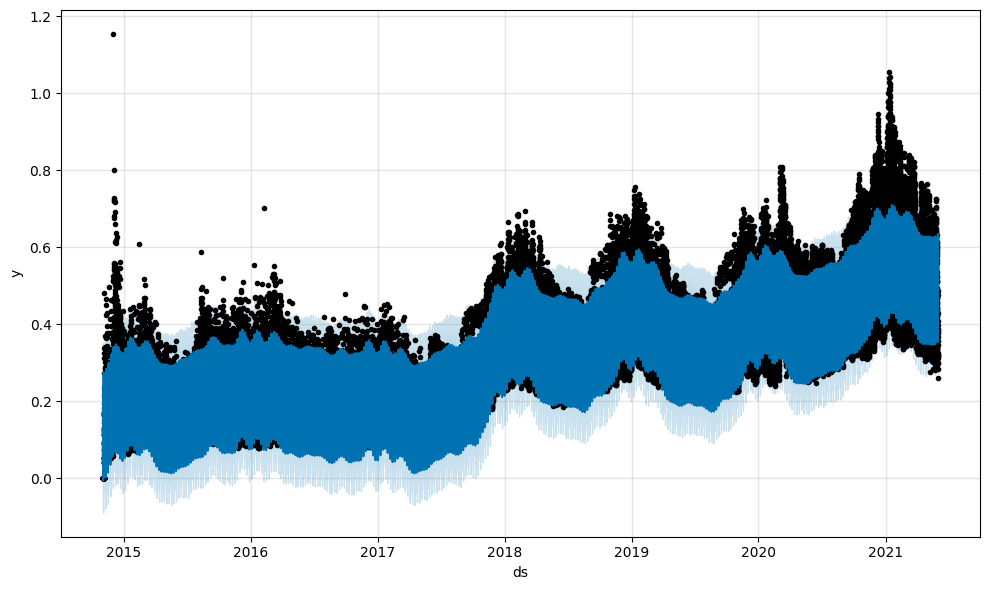

In [9]:
# Crear un dataframe para las predicciones futuras
future = model.make_future_dataframe(periods=30, freq='H')  
forecast = model.predict(future)

# Mostrar las predicciones
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Graficar las predicciones
fig = model.plot(forecast)

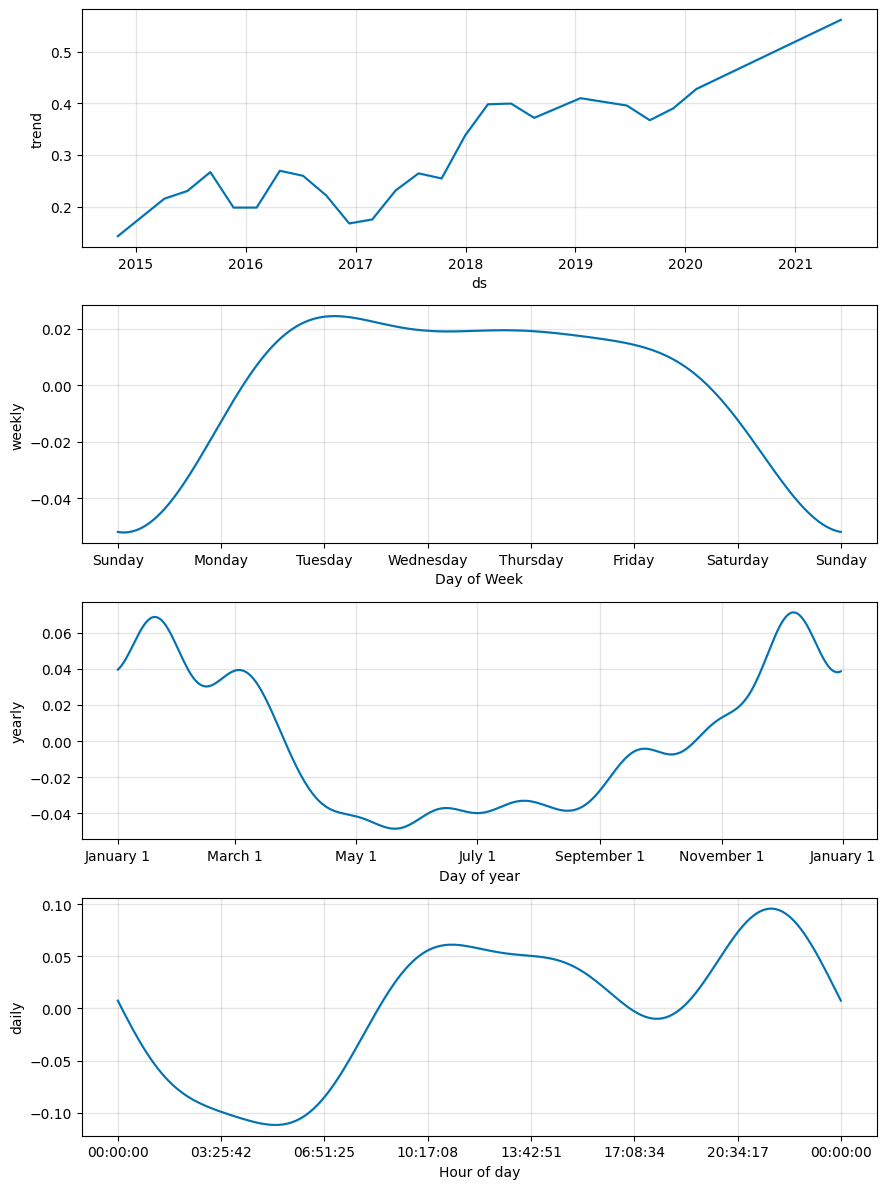

In [10]:
# Graficar los componentes de estacionalidad
fig_components = model.plot_components(forecast)

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Filtrar el último año de datos
df_consumo_medio['timestamp'] = pd.to_datetime(df_consumo_medio['timestamp'])
ultimo_anio = df_consumo_medio[df_consumo_medio['timestamp'] >= '2021-01-01']
datos_entrenamiento = df_consumo_medio[df_consumo_medio['timestamp'] < '2021-01-01']

# Preparar los datos para Prophet
df_prophet_entrenamiento = datos_entrenamiento.rename(columns={'timestamp': 'ds', 'consumo_kwh': 'y'})

In [19]:
# Crear y ajustar el modelo con los datos de entrenamiento
model_entrenamiento = Prophet()
model_entrenamiento.fit(df_prophet_entrenamiento)


14:48:10 - cmdstanpy - INFO - Chain [1] start processing
14:48:44 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Crear un dataframe para las predicciones 
future_entrenamiento = model_entrenamiento.make_future_dataframe(periods=60*24, freq='H')
forecast_entrenamiento = model_entrenamiento.predict(future_entrenamiento)

# Filtrar las predicciones para el los proximos 60 días
predicciones_ultimo_anio = forecast_entrenamiento[forecast_entrenamiento['ds'] >= '2021-01-01' ]

# Verificar si ultimo_anio contiene datos
if not ultimo_anio.empty:
	# Alinear las longitudes de y_true y y_pred
	y_true = ultimo_anio['consumo_kwh'].values[:len(predicciones_ultimo_anio)]
	y_pred = predicciones_ultimo_anio['yhat'].values[:len(y_true)]

	# Calcular las medidas de precisión
	mae = mean_absolute_error(y_true, y_pred)
	mse = mean_squared_error(y_true, y_pred)
	rmse = np.sqrt(mse)

	print(f'MAE: {mae}')
	print(f'MSE: {mse}')
	print(f'RMSE: {rmse}')
else:
	print("El dataframe 'ultimo_anio' está vacío. No se pueden calcular las medidas de precisión.")

/home/david/proyectos4/p4_venv/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


MAE: 0.09600916012398941
MSE: 0.013960640014225941
RMSE: 0.11815515229657123


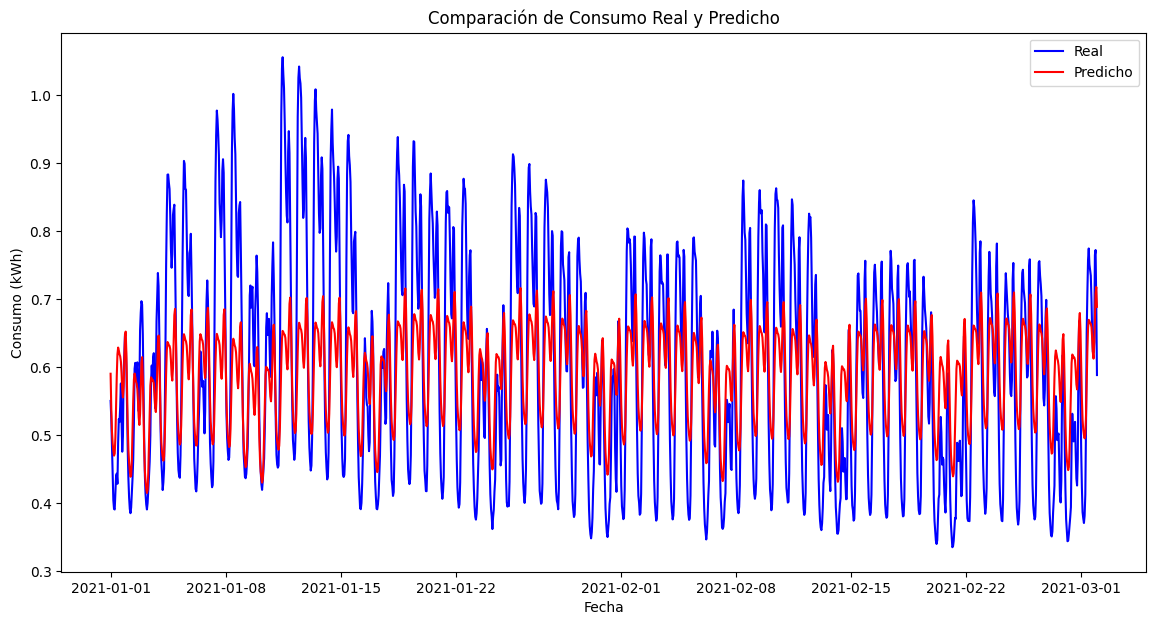

In [22]:
import matplotlib.pyplot as plt

# Asegurarse de que las longitudes de x e y sean iguales
timestamps = ultimo_anio['timestamp'].values[:len(y_true)]

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(14, 7))

# Graficar los valores reales
ax.plot(timestamps, y_true, label='Real', color='blue')

# Graficar los valores predichos
ax.plot(timestamps, y_pred, label='Predicho', color='red')

# Añadir título y etiquetas
ax.set_title('Comparación de Consumo Real y Predicho')
ax.set_xlabel('Fecha')
ax.set_ylabel('Consumo (kWh)')

# Añadir una leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

Usando data de clima

In [24]:
df_clima_bcn = pd.read_csv('data/processed/datos_clima/0200E_clima_completo.csv')
df_clima_bcn['fecha'] = pd.to_datetime(df_clima_bcn['fecha'])
df_clima_bcn.head()


,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,...,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin,hrMedia
0,2014-11-03,0200E,"BARCELONA, FABRA",BARCELONA,408,"15,6","20,6","12,7",05:17,"18,4",...,21.0,"7,2","17,8",23:02,"4,2","969,5",00,"955,2",24,94.0
1,2014-11-04,0200E,"BARCELONA, FABRA",BARCELONA,408,"12,6","8,9","8,0",23:59,"17,2",...,26.0,"5,0","18,9",01:02,"1,9","955,2",00,"946,5",05,86.0
2,2014-11-05,0200E,"BARCELONA, FABRA",BARCELONA,408,"11,4",Ip,"7,2",04:15,"15,6",...,32.0,"4,2","11,4",00:12,"6,9","961,0",24,"950,8",00,72.0
3,2014-11-06,0200E,"BARCELONA, FABRA",BARCELONA,408,"11,0","0,0","6,5",05:00,"15,4",...,30.0,"5,3","10,3",03:04,"9,7","964,5",Varias,"961,0",00,59.0
4,2014-11-07,0200E,"BARCELONA, FABRA",BARCELONA,408,"13,7",Ip,"8,8",04:09,"18,6",...,31.0,"3,6","10,8",03:22,"9,9","967,2",22,"962,2",06,72.0


In [25]:
df_consumo_medio['fecha'] = pd.to_datetime(df_consumo_medio['timestamp']).dt.date
df_consumo_medio.head()

,timestamp,consumo_kwh,fecha
0,2014-11-02 01:00:00,0.0,2014-11-02
1,2014-11-02 02:00:00,0.0,2014-11-02
2,2014-11-02 03:00:00,0.0,2014-11-02
3,2014-11-02 04:00:00,0.0,2014-11-02
4,2014-11-02 05:00:00,0.0,2014-11-02


In [26]:
# Convert 'fecha' column in df_consumo_medio to datetime format
df_consumo_medio['fecha'] = pd.to_datetime(df_consumo_medio['fecha'])

# Merge the dataframes
df_merged = pd.merge(df_consumo_medio, df_clima_bcn, on='fecha')
df_merged.head()

,timestamp,consumo_kwh,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,...,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin,hrMedia
0,2014-11-03 00:00:00,0.0,2014-11-03,0200E,"BARCELONA, FABRA",BARCELONA,408,"15,6","20,6","12,7",...,21.0,"7,2","17,8",23:02,"4,2","969,5",00,"955,2",24,94.0
1,2014-11-03 01:00:00,0.0,2014-11-03,0200E,"BARCELONA, FABRA",BARCELONA,408,"15,6","20,6","12,7",...,21.0,"7,2","17,8",23:02,"4,2","969,5",00,"955,2",24,94.0
2,2014-11-03 02:00:00,0.0,2014-11-03,0200E,"BARCELONA, FABRA",BARCELONA,408,"15,6","20,6","12,7",...,21.0,"7,2","17,8",23:02,"4,2","969,5",00,"955,2",24,94.0
3,2014-11-03 03:00:00,0.0,2014-11-03,0200E,"BARCELONA, FABRA",BARCELONA,408,"15,6","20,6","12,7",...,21.0,"7,2","17,8",23:02,"4,2","969,5",00,"955,2",24,94.0
4,2014-11-03 04:00:00,0.0,2014-11-03,0200E,"BARCELONA, FABRA",BARCELONA,408,"15,6","20,6","12,7",...,21.0,"7,2","17,8",23:02,"4,2","969,5",00,"955,2",24,94.0


In [27]:
# Eliminamos las columnas que no necesitamos
df_merged = df_merged.drop(columns=['fecha', 'indicativo', 'provincia', 'altitud'])

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Filtrar el último año de datos
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
ultimo_anio = df_merged[df_merged['timestamp'] >= '2021-01-01']
datos_entrenamiento = df_merged[df_merged['timestamp'] < '2021-01-01']

# Preparar los datos para Prophet
df_prophet_entrenamiento = datos_entrenamiento.rename(columns={'timestamp': 'ds', 'consumo_kwh': 'y'})



In [29]:
# Crear y ajustar el modelo con los datos de entrenamiento
model_entrenamiento = Prophet()
model_entrenamiento.fit(df_prophet_entrenamiento)

14:55:37 - cmdstanpy - INFO - Chain [1] start processing
14:56:08 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# Crear un dataframe para las predicciones del último año
future_entrenamiento = model_entrenamiento.make_future_dataframe(periods=60*24, freq='H')
forecast_entrenamiento = model_entrenamiento.predict(future_entrenamiento)

# Filtrar las predicciones para el último año
predicciones_ultimo_anio = forecast_entrenamiento[forecast_entrenamiento['ds'] >= '2021-01-01']

# Alinear las longitudes de y_true y y_pred
y_true = ultimo_anio['consumo_kwh'].values[:len(predicciones_ultimo_anio)]
y_pred = predicciones_ultimo_anio['yhat'].values[:len(y_true)]

# Calcular las medidas de precisión
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

/home/david/proyectos4/p4_venv/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


MAE: 0.09606742487102776
MSE: 0.01398540633376189
RMSE: 0.11825991008690093


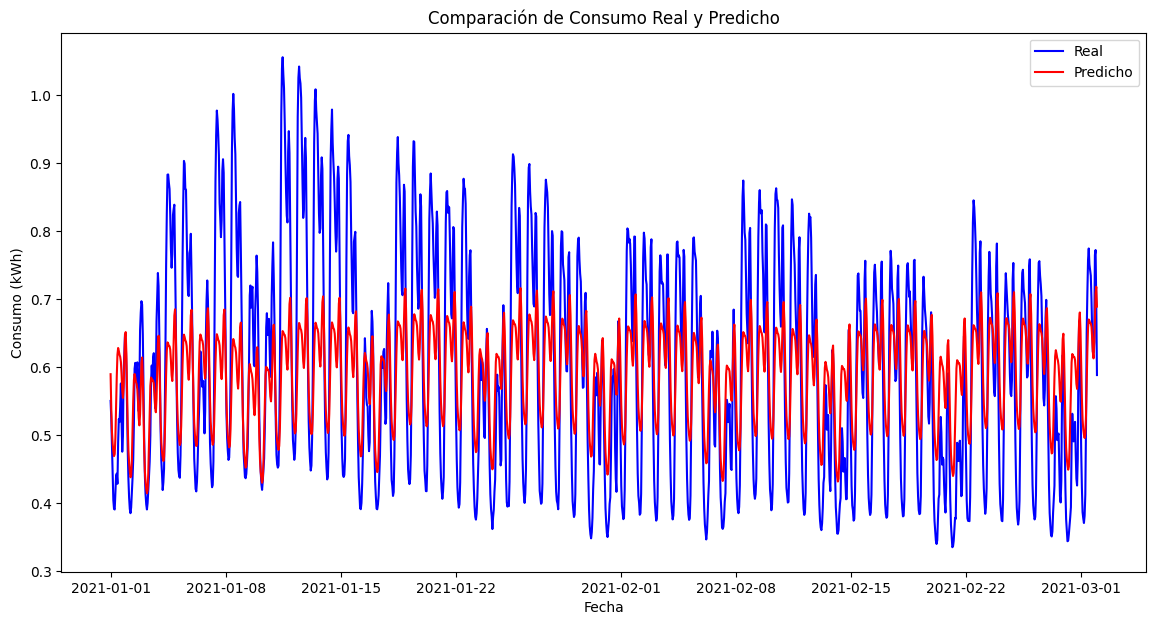

In [32]:
import matplotlib.pyplot as plt

# Asegurarse de que las longitudes de x e y sean iguales
timestamps = ultimo_anio['timestamp'].values[:len(y_true)]

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(14, 7))

# Graficar los valores reales
ax.plot(timestamps, y_true, label='Real', color='blue')

# Graficar los valores predichos
ax.plot(timestamps, y_pred, label='Predicho', color='red')

# Añadir título y etiquetas
ax.set_title('Comparación de Consumo Real y Predicho')
ax.set_xlabel('Fecha')
ax.set_ylabel('Consumo (kWh)')

# Añadir una leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

Solo datos de electricidad:
    MAE: 0.09600916012398941
    MSE: 0.013960640014225941
    RMSE: 0.11815515229657123

Electricidad y clima Barcelona:
    MAE: 0.09606742487102776
    MSE: 0.01398540633376189
    RMSE: 0.11825991008690093